In [129]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from scipy.stats import chi2_contingency
from scipy.stats import norm 
import math
from scipy import stats
from scipy.stats import t



In [2]:
health_data = pd.read_csv('healthcare-dataset-stroke-data 2.csv')

In [3]:
health_data.shape

(5110, 12)

In [4]:
health_data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [5]:
health_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
# I want to address the issue of 3.93% of missing values in bmi column; going to look for the mean value 

mean_bmi = health_data['bmi'].mean()
mean_bmi

28.893236911794673

In [7]:
health_data['bmi'].describe()

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

[]

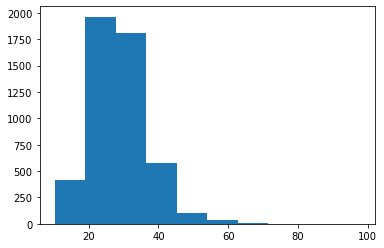

In [8]:
#visualize the BMI data on its own 

_=plt.hist(health_data['bmi'])
plt.plot()

In [9]:
#replacing the bmi N/A values with the mean bmi value 

df = health_data.replace(to_replace = np.nan , value = mean_bmi)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


[]

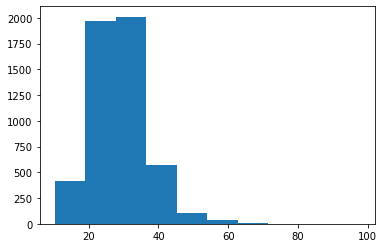

In [10]:
#re-visualizing new bmi data 

_=plt.hist(df['bmi'])
plt.plot()

In [11]:
df['bmi'].describe()

count    5110.000000
mean       28.893237
std         7.698018
min        10.300000
25%        23.800000
50%        28.400000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64

 Changing NaN values in bmi column to the mean bmi value slightly shifted the distribution; mean value is still the same, slight shift from 7.85 to 7.70 in std resulting in a quartile shift. Going to contine with this.

Type of analysis: Overall, this is a classification problem. The eventual goal is to input data and have an output that reveals whether or not a patient is likely to have a stroke. 

In [12]:
# I want to see how distribution of different variables where a stroke did occur 

df_stroke_pos = df[df['stroke']==1]
df_stroke_neg = df[df['stroke']==0]

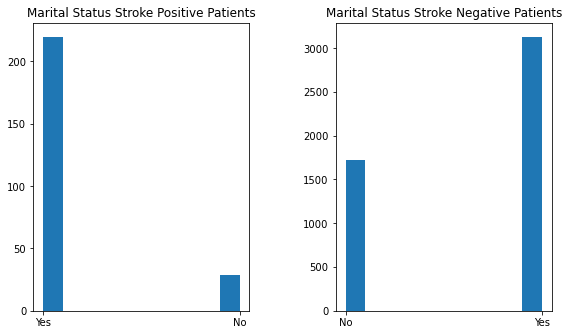

In [13]:
figs, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(df_stroke_pos['ever_married'])
ax2.hist(df_stroke_neg['ever_married'])
ax1.set_title('Marital Status Stroke Positive Patients')
ax2.set_title('Marital Status Stroke Negative Patients')
plt.subplots_adjust(left = 0.1, bottom=0.1 ,right=1.3, top=1.1,wspace=0.4, hspace=0.4)
plt.show;

In [106]:
df_stroke_pos['ever_married'].value_counts(normalize=True)

Yes    0.883534
No     0.116466
Name: ever_married, dtype: float64

In [107]:
df_stroke_neg['ever_married'].value_counts(normalize=True)

Yes    0.644518
No     0.355482
Name: ever_married, dtype: float64

Marital Status distribution comparison: Its clear that more people in the stroke positive group were married (88%); this is also true for the stroke negative patients (64.5%). The difference between the values in their respective categories (stroke pos vs stroke neg) is wider in the stroke positive group.  

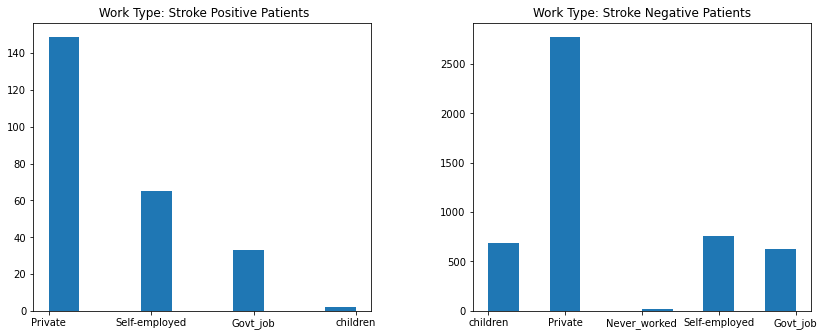

In [16]:
figs, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(df_stroke_pos['work_type'])
ax2.hist(df_stroke_neg['work_type'])
ax1.set_title(' Work Type: Stroke Positive Patients')
ax2.set_title('Work Type: Stroke Negative Patients')
plt.subplots_adjust(left = 0.2, bottom=0.1, right=2.0, top=1.1, wspace=0.3, hspace=0.3)
plt.show();

In [81]:
df_stroke_pos['work_type'].value_counts(normalize=True)

Private          0.598394
Self-employed    0.261044
Govt_job         0.132530
children         0.008032
Name: work_type, dtype: float64

In [82]:
df_stroke_neg['work_type'].value_counts(normalize=True)

Private          0.571076
Self-employed    0.155112
children         0.140918
Govt_job         0.128369
Never_worked     0.004526
Name: work_type, dtype: float64

In [19]:
df['work_type'].value_counts(normalize=True)

Private          0.572407
Self-employed    0.160274
children         0.134442
Govt_job         0.128571
Never_worked     0.004305
Name: work_type, dtype: float64

Work Type Distribution Comparison: For both the stroke positive and stroke negative groups, patients who worked a private job were the highest population (59.8% for stroke positive group / 57.1% for stroke negative group). Followed by those who were self-employed. This distribution seems fairly obvious since most of the general population tends to be privately employed. The largest difference is that none of the patients from the "Never worked" population appear in the stroke positive group. I'm not sure how significant this is since the "Never worked" patients only make up 0.43% of the overall population in this dataset. 

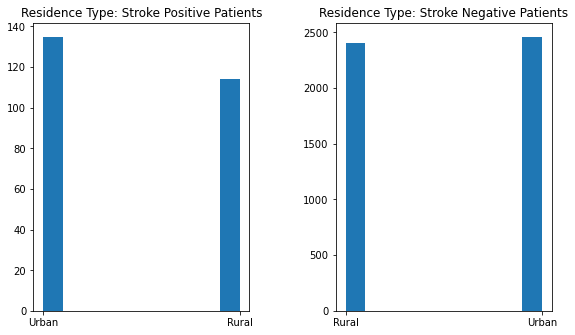

In [20]:
figs, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(df_stroke_pos['Residence_type'])
ax2.hist(df_stroke_neg['Residence_type'])
ax1.set_title('Residence Type: Stroke Positive Patients')
ax2.set_title('Residence Type: Stroke Negative Patients')
plt.subplots_adjust(left = 0.1, bottom=0.1 ,right=1.3, top=1.1,wspace=0.4, hspace=0.4)

In [24]:
df_stroke_pos['Residence_type'].value_counts()

Urban    135
Rural    114
Name: Residence_type, dtype: int64

In [25]:
df_stroke_neg['Residence_type'].value_counts()

Urban    2461
Rural    2400
Name: Residence_type, dtype: int64

Residence Type Distribution Comparison: For both the negative and positive stroke groups, the Urban population holds the majority (54.2% in stroke positive / 50.6% in stroke negative). Overall, a slightly larger percentage found in the stroke positive group (difference of 3.6%) 

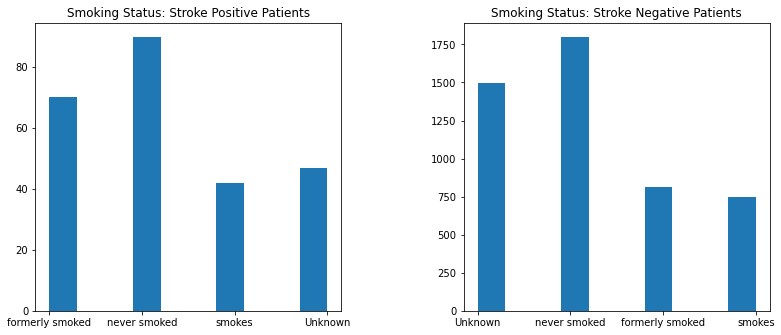

In [26]:
figs , (ax1,ax2) = plt.subplots(1,2)
ax1.hist(df_stroke_pos['smoking_status'])
ax2.hist(df_stroke_neg['smoking_status'])
ax1.set_title('Smoking Status: Stroke Positive Patients')
ax2.set_title('Smoking Status: Stroke Negative Patients')
plt.subplots_adjust(left = 0.1, bottom=0.1 ,right=1.8, top=1.1,wspace=0.4, hspace=0.4)
plt.show();

In [88]:
df_stroke_pos['smoking_status'].value_counts()

never smoked       90
formerly smoked    70
Unknown            47
smokes             42
Name: smoking_status, dtype: int64

In [89]:
df_stroke_neg['smoking_status'].value_counts()

never smoked       1802
Unknown            1497
formerly smoked     815
smokes              747
Name: smoking_status, dtype: int64

Smoking Status Distribution Comparison: Patients that have reported as "Never smoked" hold the majority in both populations (36.2% for stroke positive / 37.1% for stroke negative). Interestingly enough, the smallest group for the stroke positive group are the patients who reported as smokers (16.9%). This group deems to be the most difficult still since it has such a large "unknown" population.

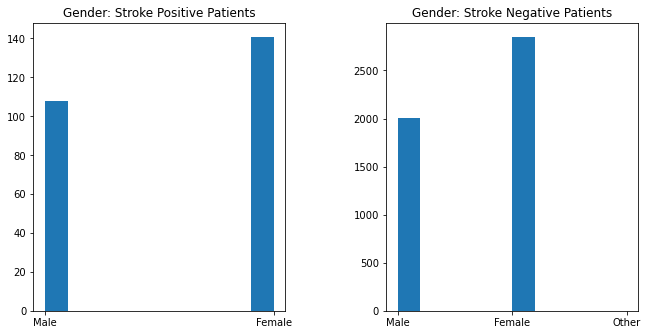

In [29]:
figs,(ax1,ax2) = plt.subplots(1,2)
ax1.hist(df_stroke_pos['gender'])
ax2.hist(df_stroke_neg['gender'])
ax1.set_title('Gender: Stroke Positive Patients')
ax2.set_title('Gender: Stroke Negative Patients')
plt.subplots_adjust(left = 0.1, bottom=0.1 ,right=1.5, top=1.1,wspace=0.4, hspace=0.4)
plt.show();

In [100]:
df_stroke_pos['gender'].value_counts(normalize=True)

Female    0.566265
Male      0.433735
Name: gender, dtype: float64

In [101]:
df_stroke_neg['gender'].value_counts(normalize=True)

Female    0.586916
Male      0.412878
Other     0.000206
Name: gender, dtype: float64

In [32]:
df['gender'].value_counts(normalize=True)

Female    0.585910
Male      0.413894
Other     0.000196
Name: gender, dtype: float64

Gender Distribution Comparison: Females are the majority in both population groups (56.6% in the stroke positive group / 58.7% in the stroke negative group). This overall gender distribution for the total population is not even in the first place, women make up a majority by over 17%

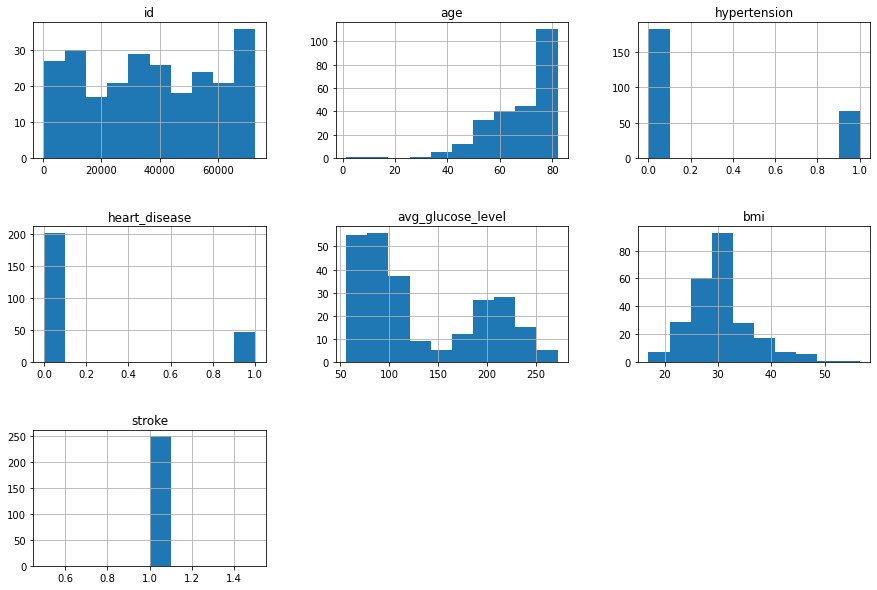

In [33]:
_=df_stroke_pos.hist(figsize=(15,10))
_=plt.subplots_adjust(hspace=0.5);

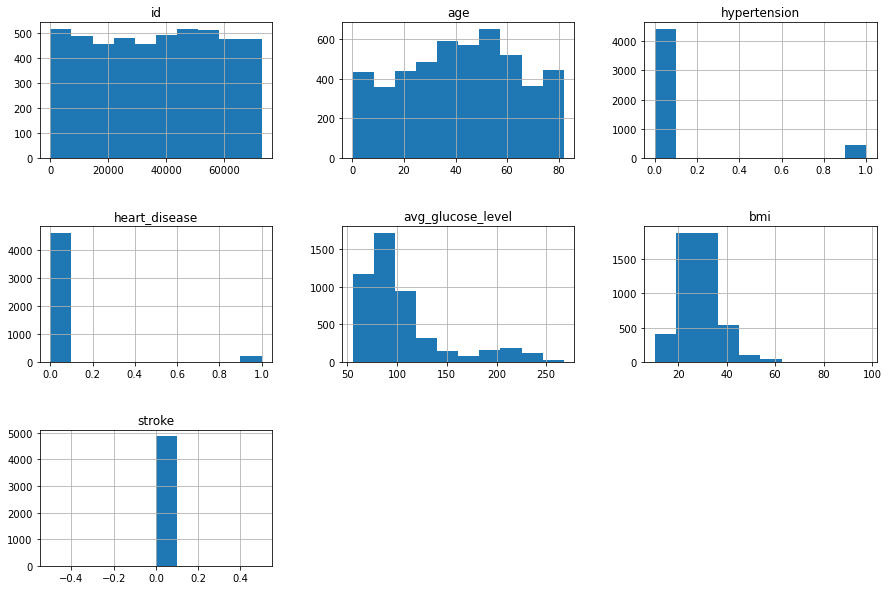

In [34]:
_=df_stroke_neg.hist(figsize=(15,10))
_=plt.subplots_adjust(hspace=0.5);

Subplot Comparisons: 

 - Age: There seems to be a general trend to the age distribution in stroke positive patients, it looks like the older in age, the higher rate of reported strokes. 
 
 - Hypertension & Heart Disease : There seems to be a few more reported strokes for those with either hypertension OR heart disease between the two groups (stroke positive vs. stroke negative). 
 
 - Average Glucose Levels: The distribution for stroke positive patients looks a little more irregular than the dsitribution for stroke negative patients.  
 
 - BMI: These distributions seem to be different shapes but the overall range seems about the same -- worried the difference in shape is due to binning bias 

I want to take a closer look at the age, avg_glucose, and bmi charts on their own. 



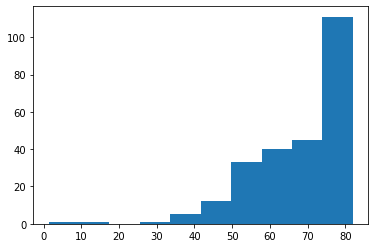

In [35]:
_= plt.hist(df_stroke_pos['age'])

In [36]:
df_stroke_pos['age'].describe()

count    249.000000
mean      67.728193
std       12.727419
min        1.320000
25%       59.000000
50%       71.000000
75%       78.000000
max       82.000000
Name: age, dtype: float64

In [37]:
df_stroke_pos[df_stroke_pos['age']< 30]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,28.893237,Unknown,1
245,49669,Female,14.00,0,0,No,children,Rural,57.93,30.900000,Unknown,1


It looks like patients who reported as stroke positive are generally in older groups, with 75% of patients being above 59 years of age and the average age being around 68 years of age. 

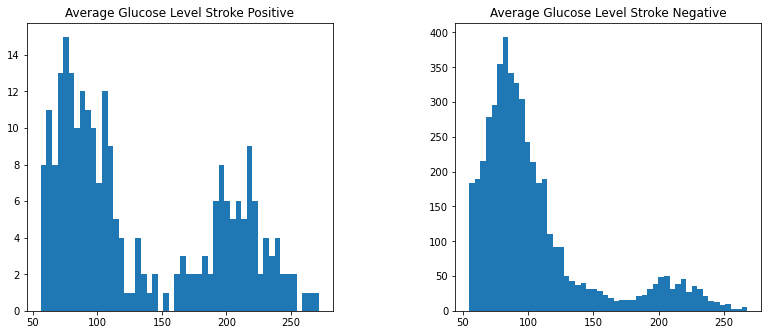

In [38]:
figs, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(df_stroke_pos['avg_glucose_level'],bins=50)
ax2.hist(df_stroke_neg['avg_glucose_level'],bins=50)
ax1.set_title('Average Glucose Level Stroke Positive')
ax2.set_title('Average Glucose Level Stroke Negative')
plt.subplots_adjust(left = 0.1, bottom=0.1 ,right=1.8, top=1.1,wspace=0.4, hspace=0.4)
plt.show()

In [39]:
df_stroke_pos['avg_glucose_level'].describe()

count    249.000000
mean     132.544739
std       61.921056
min       56.110000
25%       79.790000
50%      105.220000
75%      196.710000
max      271.740000
Name: avg_glucose_level, dtype: float64

In [40]:
(df_stroke_pos['avg_glucose_level']>199).value_counts(normalize=True)

False    0.763052
True     0.236948
Name: avg_glucose_level, dtype: float64

In [41]:
(df_stroke_neg['avg_glucose_level']>199).value_counts(normalize=True)

False    0.920592
True     0.079408
Name: avg_glucose_level, dtype: float64

In [42]:
(df_stroke_pos['avg_glucose_level']<70).value_counts(normalize=True)

False    0.891566
True     0.108434
Name: avg_glucose_level, dtype: float64

In [43]:
(df_stroke_neg['avg_glucose_level']<70).value_counts(normalize=True)

False    0.850442
True     0.149558
Name: avg_glucose_level, dtype: float64

In [44]:
(df_stroke_pos['avg_glucose_level']>140).value_counts(normalize=True)

False    0.626506
True     0.373494
Name: avg_glucose_level, dtype: float64

In [45]:
(df_stroke_neg['avg_glucose_level']>140).value_counts(normalize=True)

False    0.850237
True     0.149763
Name: avg_glucose_level, dtype: float64

Glucose levels are difficult to report on since a lot of assumptions need to be made as to when the levels were taken -- i.e. Before eating, after fasting, after eating, after working out, etc. Since most glucose testing occurs after a period of fasting, I'll assume this for all patients 

 - Blood sugar levels below 140 are 'normal'
 - Blood sugar levels above 200 indicates diabetes
 - Blood sugar levels between 140 and 199 indicates prediabetes
 - Blood sugar levels below 70 indicate hypoglycemia 

The average value in our distribution falls at 132.54 which is a normal reading -- it looks like 24.6% of patients are within the diabetic range (75th percentile = 196.71) and 10.8% of patients are within the prediabetic range (25th percentile = 79.79). 

37.3% of patients are above the 'normal' range -- these patients exist within the prediabetic/diabetic range 

Overall, 48.1% of stroke positive patients report to have abnormal glucose readings. 

Excess sugar in the blood leads to damage of the blood vessels which makes for the higher stroke risk 

Its thought that hypoglycemia can lead to increased free radicals distributing throughout the body, which also damage the blood vessels 

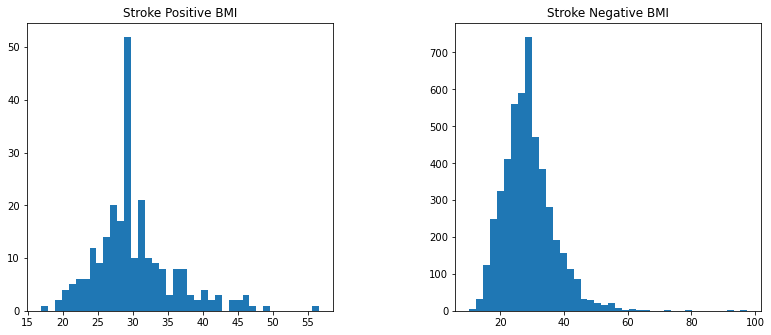

In [46]:
figs, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(df_stroke_pos['bmi'],bins=40)
ax2.hist(df_stroke_neg['bmi'],bins=40)
ax1.set_title('Stroke Positive BMI')
ax2.set_title('Stroke Negative BMI')
plt.subplots_adjust(left = 0.1, bottom=0.1 ,right=1.8, top=1.1,wspace=0.4, hspace=0.4)
plt.show()

In [47]:
df_stroke_pos['bmi'].describe()

count    249.000000
mean      30.217789
std        5.825589
min       16.900000
25%       27.000000
50%       28.893237
75%       32.500000
max       56.600000
Name: bmi, dtype: float64

According to the CDC: 
- A healthy BMI range is within 18.5 - 24.9 
- A BMI between 25.0 - 29.9 falls within the 'overweight' range 
- A BMI greater than 30.0 falls within the obese range

In [48]:
(df_stroke_pos['bmi']<18.5).value_counts(normalize=True)

False    0.995984
True     0.004016
Name: bmi, dtype: float64

In [49]:
df_stroke_pos['bmi'].between(25.0,29.9).value_counts(normalize=True)

False    0.538153
True     0.461847
Name: bmi, dtype: float64

In [50]:
(df_stroke_pos['bmi']>30).value_counts(normalize=True)

False    0.614458
True     0.385542
Name: bmi, dtype: float64

In [51]:
(df_stroke_pos['bmi']>25).value_counts(normalize=True)

True     0.84739
False    0.15261
Name: bmi, dtype: float64

A majority of stroke positive patients were either overweight or obese -- 84.7%. A larger percentage of this group fell within the overweight range (BMI 25.0 - 29.9) with a percentage of 46.2%. 

In [52]:
df_stroke_neg['bmi'].describe()

count    4861.000000
mean       28.825388
std         7.776203
min        10.300000
25%        23.600000
50%        28.300000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64

In [53]:
(df_stroke_neg['bmi']<18.5).value_counts(normalize=True)

False    0.930878
True     0.069122
Name: bmi, dtype: float64

In [54]:
df_stroke_neg['bmi'].between(25.0,29.9).value_counts(normalize=True)

False    0.69245
True     0.30755
Name: bmi, dtype: float64

In [55]:
(df_stroke_neg['bmi']>30).value_counts(normalize=True)

False    0.630323
True     0.369677
Name: bmi, dtype: float64

In [56]:
(df_stroke_neg['bmi']>25).value_counts(normalize=True)

True     0.677227
False    0.322773
Name: bmi, dtype: float64

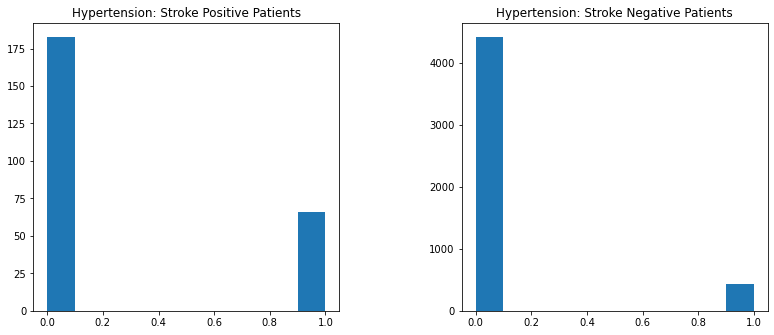

In [57]:
figs,(ax1,ax2) = plt.subplots(1,2)
ax1.hist(df_stroke_pos['hypertension'])
ax2.hist(df_stroke_neg['hypertension'])
ax1.set_title('Hypertension: Stroke Positive Patients')
ax2.set_title('Hypertension: Stroke Negative Patients')
plt.subplots_adjust(left = 0.1, bottom=0.1 ,right=1.8, top=1.1,wspace=0.4, hspace=0.4)
plt.show();

In [117]:
(df_stroke_pos['hypertension']).value_counts(normalize=True)

0    0.73494
1    0.26506
Name: hypertension, dtype: float64

In [118]:
(df_stroke_neg['hypertension']).value_counts(normalize=True)

0    0.911129
1    0.088871
Name: hypertension, dtype: float64

It looks like there is a noticeable difference for stroke positive patients with hypertension when comparing to stroke negative patients. The majority for both groups is still those who do not have hypertension, but the distribution of people in the stroke positive group with hypertension is noticeably different than those in the stroke negative group. 26.5% of patients with hypertension fall in the stroke positive group while only 8.8% fall in the stroke negative group. 

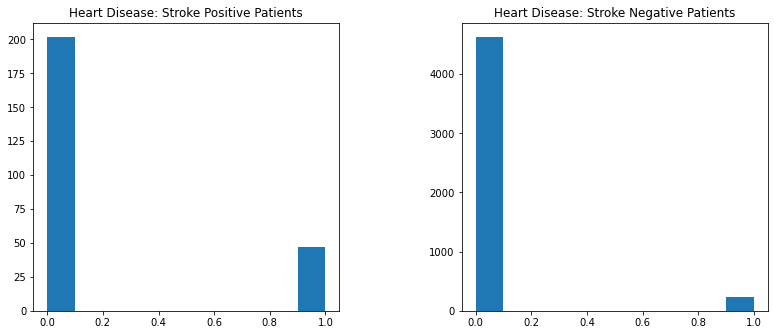

In [60]:
figs,(ax1,ax2) = plt.subplots(1,2)
ax1.hist(df_stroke_pos['heart_disease'])
ax2.hist(df_stroke_neg['heart_disease'])
ax1.set_title('Heart Disease: Stroke Positive Patients')
ax2.set_title('Heart Disease: Stroke Negative Patients')
plt.subplots_adjust(left = 0.1, bottom=0.1 ,right=1.8, top=1.1,wspace=0.4, hspace=0.4)
plt.show();

In [121]:
(df_stroke_pos['heart_disease']).value_counts(normalize=True)

0    0.811245
1    0.188755
Name: heart_disease, dtype: float64

In [122]:
(df_stroke_neg['heart_disease']).value_counts(normalize=True)

0    0.95289
1    0.04711
Name: heart_disease, dtype: float64

Noticeable difference in heart disease distribution. 18.9% of patients with heart disease in the stroke positive group and only 4.7% in the stroke negative group. 

I wanted to look at the BMI distribution for both stroke positive and negative patients since the distributions looked so different but overall range seemed visually similar. 

Value Breakdown: 

- Overweight : 47.2% (stroke pos)/ 30.8% (stroke neg)
- Obese : 38.6% (stroke pos) / 37% (stroke neg) 

It does look like the stroke positive group had more patients that were either overweight or obese. Total values for overweight & obese patients are as follows: 84.7% (stroke positive) and 67.7% (stroke negative) 

In [90]:
# starting process of running Chi-Square Tests Residence Type: 

Res_data = {'Stroke_Positive':[135,114],'Stroke_Negative':[2461,2400]}

In [91]:
Res_type = pd.DataFrame(Res_data, index=['Urban','Rural'])
Res_type

,Stroke_Positive,Stroke_Negative
Urban,135,2461
Rural,114,2400


In [92]:
chi2,p,dof, ex = chi2_contingency(Res_type,correction=False)
print(chi2, '{:.10f}'.format(p))

1.221027840116894 0.2691590323


***Residence Type Chi Square Results***

* P value is 0.2691590323 is greater than the accepted alpha value (0.05)
* No statistical significance for Residence type 

In [93]:
work_data = {'Stroke Positive': [149,65,33,0,2],'Stroke Negative':[2776,754,624,22,685]}

In [94]:
Work_type = pd.DataFrame(work_data, index=['Private','Self-Employed','Government Job','Never Worked','Children'])
Work_type

,Stroke Positive,Stroke Negative
Private,149,2776
Self-Employed,65,754
Government Job,33,624
Never Worked,0,22
Children,2,685


In [95]:
chi2,p,dof,ex = chi2_contingency(Work_type,correction=False)
print(chi2,'{:.10f}'.format(p))

49.163511976675295 0.0000000005


***Work Type Chi Square Results***
* p value is 0.0000000005; much lower than the accepted alpha value (0.05)
* Statistical significance shown for Work Type

In [96]:
smoking_data = {'Stroke Positive':[90,70,47,42],'Stroke Negative':[1802,815,1497,747]}
smoking_status = pd.DataFrame(smoking_data,index= ['Never Smoked','Formerly Smoked','Unknown','Smokes'])
smoking_status

,Stroke Positive,Stroke Negative
Never Smoked,90,1802
Formerly Smoked,70,815
Unknown,47,1497
Smokes,42,747


In [97]:
chi2,p,dof,ex = chi2_contingency(smoking_status,correction=False)
print(chi2,'{:.10f}'.format(p))

29.147269191399264 0.0000020854


***Smoking Status Chi Square Results***
* p value is 0.0000020854l; lower than the accepted alpha value (0.05)
* Statistical significance shown for Smoking status

In [102]:
gender_data = {'Stroke Positive':[141,108],'Stroke Negative':[2853,2007]}
gender_status = pd.DataFrame(gender_data, index=['Female','Male'])
gender_status

,Stroke Positive,Stroke Negative
Female,141,2853
Male,108,2007


In [103]:
chi2,p,dof,ex = chi2_contingency(gender_status, correction = False)
print(chi2,'{:.10f}'.format(p))

0.4212743419562929 0.5163018564


***Gender Chi Square Results*** 

* p value is 0.5163018564; higher than the accepted alpha value(0.05)
* No statistical significance shown for Gender 

In [109]:
marital_data = {'Stroke Positive':[220,29],'Stroke Negative':[3133,1728]}
marital_status = pd.DataFrame(marital_data, index=['Has Been Married','Has Never Been Married'])
marital_status

,Stroke Positive,Stroke Negative
Has Been Married,220,3133
Has Never Been Married,29,1728


In [112]:
chi2,p,dof,ex = chi2_contingency(marital_status,correction = False)
print(chi2,'{:.10f}'.format(p))

59.97862306999247 0.0000000000


***Marital History Chi Square Results***

* p value is 0.0
* Stastical significance shown for marital status

In [115]:
hyper_data= {'Stroke Positive':[66,183],'Stroke Negative':[432,4429]}
hyper_status = pd.DataFrame(hyper_data,index=['Has Hypertension','No Hypertension'])
hyper_status

,Stroke Positive,Stroke Negative
Has Hypertension,66,432
No Hypertension,183,4429


In [116]:
chi2,p,dof,ex = chi2_contingency(hyper_status,correction=False)
print(chi2,'{:.10f}'.format(p))

83.59647297303054 0.0000000000


***Hypertension Chi Square Results***

* p value is 0.0 
* Statistical significance found for Hypertension 

In [123]:
heart_data = {'Stroke Positive':[47,202],'Stroke Negative':[229,4632]}
heart_status = pd.DataFrame(heart_data,index = ['Heart Disease','No Heart Disease'])
heart_status

,Stroke Positive,Stroke Negative
Heart Disease,47,229
No Heart Disease,202,4632


In [124]:
chi2,p,dof,ex = chi2_contingency(heart_status,correction=False)
print(chi2,'{:.10f}'.format(p))

93.01112941392964 0.0000000000


***Heart Disease Chi Square Results***

* p value is 0.0 
* Statistical significance shown for heart disease 

In [136]:
# t-test 

calc_t_bmi = stats.ttest_ind(df_stroke_pos['bmi'],df_stroke_neg['bmi'])
calc_t_bmi

Ttest_indResult(statistic=2.785637387412085, pvalue=0.005361957129403547)

In [135]:
calc_t_gluc = stats.ttest_ind(df_stroke_pos['avg_glucose_level'],df_stroke_neg['avg_glucose_level'])
calc_t_gluc

Ttest_indResult(statistic=9.513352175431471, pvalue=2.7678105194741054e-21)

In [137]:
calc_t_age = stats.ttest_ind(df_stroke_pos['age'],df_stroke_neg['age'])
calc_t_age

Ttest_indResult(statistic=18.08083426887953, pvalue=7.0307775129939774e-71)

***Numerical Value t-test Results*** 

* It looks like all numerical value data that was tested (BMI, Average Glucose Level, and Age) have a p value lower than 0.05 and hold statistical significance 

In [139]:
# want to check significance of smoking column without the "unknown" values 

df_smoking_known_pos = df_stroke_pos[df_stroke_pos['smoking_status']!='Unknown']
df_smoking_known_pos['smoking_status'].value_counts()

never smoked       90
formerly smoked    70
smokes             42
Name: smoking_status, dtype: int64

In [140]:
df_smoking_known_neg = df_stroke_neg[df_stroke_neg['smoking_status']!='Unknown']
df_smoking_known_neg['smoking_status'].value_counts()

never smoked       1802
formerly smoked     815
smokes              747
Name: smoking_status, dtype: int64

In [141]:
known_smoking_data = {'Stroke Positive':[90,70,42],'Smoking Negative':[1802,70,42]}
known_smoking_status = pd.DataFrame(known_smoking_data,index=['Never Smoked','Formerly Smoked','Smokes'])
known_smoking_status

,Stroke Positive,Smoking Negative
Never Smoked,90,1802
Formerly Smoked,70,70
Smokes,42,42


In [142]:
chi2,p,dof,ex = chi2_contingency(known_smoking_status,correction=False)
print(chi2,'{:.10f}'.format(p))

474.7847664550665 0.0000000000


The original p value for the smoking status chi square results was 0.0000020854; it looks like the p value has only decreased when we stopped considering the "unknown" values of patient's smoking status. 

***SUMMARY*** : 

What has been done / discovered so far: 
* Replaced the missing BMI values for the average BMI 
* Testing for statistical significance:
    * Categorial Data that showed statistical significance (Chi Square Testing):
            - Work type
            - Smoking status 
            - Marital status 
            - Hypertension
            - Heart Disease
    * Numerical Data that showed statistical significance (t-test):
            - Age
            - BMI
            - Avg Glucose 
            
               - concern here is that both the AVG Glucose levels and age are not normally distributed 
            